Several branches corresponding to different models are created on the following github page:
https://github.com/kcirtap2014/question_categorizer

This branch is different in the corpus creation, we create the corpus out of the tags in the train set. 
Only from train set because otherwise we would have commited some data leakage.

In [1]:
import os
import pandas as pd
import seaborn as sns
import string
import re
from collections import defaultdict
from helper_functions import group_sort, unique_values, freq_stats_corpora


sns.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Mission
Développer un système de suggestion de tag pour le site stackoverflow

# Load Data

In [2]:
cur_dir = os.path.dirname(os.getcwd())
num_db = 1
df = pd.DataFrame([])

for i in range(num_db):
    df = df.append(
        pd.read_csv(
            cur_dir + "/db/QueryResults%d.csv" % (i + 1), index_col=0))

In [3]:
df.shape

(50000, 21)

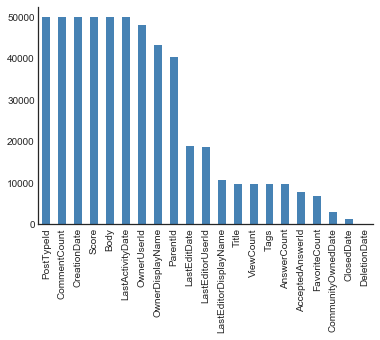

In [4]:
df_count = df.count().sort_values(ascending=False)
fig, ax = plt.subplots()
df_count.plot.bar(color="steelblue", ax=ax)
sns.despine()

__Observation__:
- Each post has an id, PostTypeId, CommentCount, CreationDate, Score and LastActivityDate
- User information are given by OwnerUserId and OwnerDisplayName, almost all posts are given by distinct user.
- Tags have a significant missing values -> users do not tag much

Here, we are interested in analysing the title and body and then suggest tags to users.

In the *unsupervised learning*, tags are not necessary, but in *supervised learning*, tags are the target variable.

In [471]:
# Combine columns
# add an empty space for distinction
df_text = pd.DataFrame(list(zip(df.Title,
                                df.Body)), index = df.index).rename(columns={
                                    0: 'TITLE',
                                    1: 'BODY',
                                })

In [477]:
def stringbetweencode(data):
    p = re.compile("<code>(.+?)<\/code>", flags=re.DOTALL)
    return p.findall(data) 

def tag_between_brackets(data):
    if pd.notnull(data):
        p = re.compile(r'<(.*?)>')
        return p.findall(data)
    return data

#df_text["CODE"] = np.nan
df_text["CODE"] = df_text["BODY"].apply(stringbetweencode) 
df_text["TAGS"] = df["Tags"].apply(tag_between_brackets) 

# EDA for Tags

In [484]:
from nltk import FreqDist
from nltk.tokenize import word_tokenize

df_tags = df_text[df_text.TAGS.notnull()]["TAGS"]

# combine all tokens together for freq dist
tagslist = df_tags.sum()

# count frequency of each tag
# How many documents are tagged with a specific tag?
tagsfreq = FreqDist(tagslist)

In [485]:
from operator import itemgetter
# sort by values in descending order
sorted_tagsfreq = sorted(tagsfreq.items(), key=itemgetter(1), reverse=True)
tags_key, tags_value = zip(*sorted_tagsfreq)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


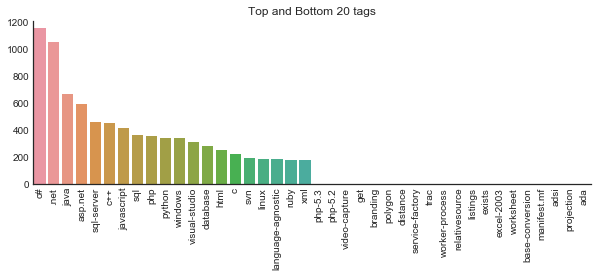

In [486]:
# prepare for sns.barplot
fig, ax = plt.subplots( figsize=(10, 3))

n_element = 20
x_tags = np.array(tags_key[:n_element]+ tags_key[-n_element:])
y_tags = np.array(tags_value[:n_element]+ tags_value[-n_element:])
sns.barplot(x_tags, y_tags, ax=ax)
ax.set_xticklabels(x_tags, rotation=90)
ax.set_title('Top and Bottom 20 tags')
sns.despine()

In [199]:
pd.Series(tags_value).describe([0.5, 0.75,0.9,0.95])

count    3745.000000
mean        7.397597
std        37.596823
min         1.000000
50%         1.000000
75%         4.000000
90%        11.000000
95%        24.000000
max      1152.000000
dtype: float64

__Observation__:
- 50% of the tags only occur once, we will eliminate tags that have low counts, taking the arg of 75% as threshold

### Remove low count tags 

In [487]:
def remove_low_count_tags(data):
    reduced = [el for el in data if el in set(tags_key_reduced)]

    if not reduced:
        reduced = np.NaN
    return reduced

# drop keywords that have less than tag_freq
quartile = 0.95
n_tag = pd.Series(tags_value).quantile([quartile]).values[0]
sorted_tagsfreq_reduced = [el for el in sorted_tagsfreq if el[1] > n_tag]
tags_key_reduced, tags_value_reduced = zip(*sorted_tagsfreq_reduced)
df_tags_temp = df_tags.apply(remove_low_count_tags)
df_tags_reduced = df_tags_temp[df_stags_temp.notnull()]

# Text preprocessing with scikit learn and NLTK

In [488]:
from sklearn.decomposition import LatentDirichletAllocation
from nltk import regexp_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pdb
wnl = WordNetLemmatizer()


def convert_tag(tag):
    """
    Convert the tag given by nltk.pos_tag 
    to the tag used by wordnet.synsets
    """
    tag_dict = {'N': 'n', 'J': 'a', 'R': 'r', 'V': 'v'}
    try:
        return tag_dict[tag[0]]
    except KeyError:
        # defalut value
        return 'n'  #None


def lemmatizer(doc):
    """
    returns lemmatized tokens after removing stop words and pos tagging
    
    Parameters:
    -----------
    doc: pandas dataframe
        text description in df
    
    Return:
    -------
    pandas dataframe
        lemmatized, pos_tagged, and removed stopwords tokens
    """
    if pd.notnull(doc):
        # add words to stoplist, previously punctuations have been removed,
        # so we should do the same for the stoplist
        stoplist = [striphtmlpunct(x)
                    for x in stopwords.words('english')] + ['im', 'ive']
        #stoplist = stopwords.words('english') + [
        #    "i've", "either", "i'm", "i'd", "would", "could", 'it', "like",
        #    "something", "also", "might", "want", 'this', 'make', 'sure'
        #]

        lemmatized = []

        regex_tokens = regexp_tokenize(doc, pattern='\w+\S+|\.\w+')
        
        for word, p_tags in pos_tag(regex_tokens):
            if word not in set(stoplist):
                convert_pos_tag = convert_tag(p_tags)
                lemmatized.append(wnl.lemmatize(word, pos=convert_pos_tag))
   
        return pd.Series(' '.join(lemmatized))
    return pd.Series(doc)


def striphtmlpunct(data):
    # remove html tags, code unnecessary punctuations
    # <.*?> to remove everything between <>
    # [^\w\s+\.\-\#\+] remove punctuations except .-#+
    # (\.{1,3})(?!\S) negative lookahead assertion: only match .{1,3} that
    # is followed by white space
    if pd.notnull(data):
        p = re.compile(r'<.*?>|[^\w\s+\.\-\#\+]')
        res = p.sub('', data)
        pe = re.compile('(\.{1,3})(?!\S)')
        
        return pe.sub('', res)
    
    return data


def striptabs(data):
    # remove tabs breaklines
    p = re.compile(r'(\r\n)+|\r+|\n+|\t+/i')
    return p.sub(' ', data)

def lower(data):
    if pd.notnull(data):
        return data.lower()
    return data


# remove html tags
df_text["BODY_STRIPPED"] = df_text.BODY.apply(lower).apply(
    striphtmlpunct).apply(striptabs)
df_text["CODE_STRIPPED"] = df_text.CODE.apply(
    lambda x: [striptabs(line.lower()) for line in x if x])
df_text["TITLE_STRIPPED"] = df_text.TITLE.apply(lower).apply(striphtmlpunct)

# remove stop words, pos_tag, and lemmatize
df_text["BODY_LEMMATIZED"] = df_text["BODY_STRIPPED"].apply(lemmatizer)
df_text["TITLE_LEMMATIZED"] = df_text["TITLE_STRIPPED"].apply(lemmatizer)

In [489]:
df_text.head()

,TITLE,BODY,TAG,CODE,TAGS,BODY_STRIPPED,CODE_STRIPPED,TITLE_STRIPPED,BODY_LEMMATIZED,TITLE_LEMMATIZED
Id,,,,,,,,,,
4,"While applying opacity to a form, should we us...",<p>I want to use a track-bar to change a form'...,<c#><winforms><type-conversion><decimal><opacity>,[decimal trans = trackBar1.Value / 5000;\nthis...,"[c#, winforms, type-conversion, decimal, opacity]",i want to use a track-bar to change a forms op...,[decimal trans = trackbar1.value / 5000; this....,while applying opacity to a form should we use...,want use track-bar change form opacity code de...,apply opacity form use decimal double value
6,Percentage width child element in absolutely p...,<p>I have an absolutely positioned <code>div</...,<html><css><css3><internet-explorer-7>,"[div, div, div]","[html, css, css3, internet-explorer-7]",i have an absolutely positioned div containing...,"[div, div, div]",percentage width child element in absolutely p...,absolutely position div contain several child ...,percentage width child element absolutely posi...
7,NaN,<p>An explicit cast to double like this isn't ...,NaN,[double trans = (double) trackBar1.Value / 500...,NaN,an explicit cast to double like this isnt nece...,[double trans = (double) trackbar1.value / 500...,NaN,explicit cast double like necessary double tra...,NaN
9,How do I calculate someone's age in C#?,<p>Given a <code>DateTime</code> representing ...,<c#><.net><datetime>,[DateTime],"[c#, .net, datetime]",given a datetime representing a persons birthd...,[datetime],how do i calculate someones age in c#,give datetime represent person birthday calcul...,calculate someone age c#
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,[DateTime],"[c#, datetime, time, datediff, relative-time-s...",given a specific datetime value how do i displ...,[datetime],calculate relative time in c#,give specific datetime value display relative ...,calculate relative time c#


### Eliminate entries without tags
- since we have remove low count tags, some entries will be tagless, we remove these entries for supervised learning 

In [490]:
df_text_reduced = df_text.loc[df_stags_reduced.index]

In [491]:
print("%.1f%% of the data are retained" %(100*len(df_text_reduced)/len(df_tags)))

91.4% of the data are retained


In [492]:
df_text_reduced.sample(3, random_state=344)

,TITLE,BODY,TAG,CODE,TAGS,BODY_STRIPPED,CODE_STRIPPED,TITLE_STRIPPED,BODY_LEMMATIZED,TITLE_LEMMATIZED
Id,,,,,,,,,,
61535,How To Discover RSS Feeds for a given URL,<p>I get a URL from a user. I need to know:<br...,<php><rss><feeds><discover><atom-feed>,[],"[php, rss, feeds, discover, atom-feed]",i get a url from a user i need to know a is th...,[],how to discover rss feeds for a given url,get url user need know url valid r feed valid ...,discover r feed give url
45407,Is there any difference between the box models...,<p>What are the main differences (if any) betw...,<firefox><browser><internet-explorer-8>,[],"[firefox, browser, internet-explorer-8]",what are the main differences if any between t...,[],is there any difference between the box models...,main difference box model ie8 firefox3 main di...,difference box model ie8 firefox3
45898,Opening a non-standard URL in a Cocoa app,<p>In an application that I'm writing I have s...,<objective-c><macos><cocoa>,[NSWorkspace* ws = [NSWorkspace sharedWorkspac...,"[objective-c, macos, cocoa]",in an application that im writing i have some ...,[nsworkspace* ws = [nsworkspace sharedworkspac...,opening a non-standard url in a cocoa app,application write code like nsworkspace ws nsw...,open non-standard url cocoa app


In [493]:
df_text_reduced.iloc[39].BODY

"<p>This is something I've pseudo-solved many times and have never quite found a solution for.</p>\n\n<p>The problem is to come up with a way to generate <code>N</code> colors, that are as distinguishable as possible where <code>N</code> is a parameter.</p>\n"

In [494]:
df_text_reduced.iloc[39].BODY_STRIPPED

'this is something ive pseudo-solved many times and have never quite found a solution for the problem is to come up with a way to generate n colors that are as distinguishable as possible where n is a parameter '

In [495]:
df_text_reduced.iloc[39].BODY_LEMMATIZED

'something pseudo-solved many time never quite found solution problem come way generate color distinguishable possible parameter'

## Bag-of-words distribution associated to a tag

### On text title

In [231]:
df_tags_title = pd.DataFrame(
    list(
        zip(df_stags_reduced,
            df_text_reduced.loc[df_stags_reduced.index, "TITLE_LEMMATIZED"]))).rename(
                columns={
                    0: "elkey",
                    1: "elvalue"
                })

In [232]:
corpfreq_title, corpstats_title, corpora_title = freq_stats_corpora(
    df_tags_title)

In [233]:
# sort by values in descending order
sorted_corpfreq_title = defaultdict(list)
cutoff = 10

for tag, tagfreq in corpfreq_title.items():
    # only add into sorted_corpfreq if the word occurencces are>50
    if sum(list(tagfreq.values())) > cutoff:
        sorted_corpfreq_title[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)

/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


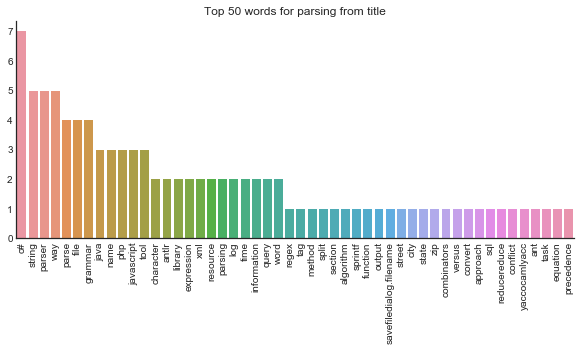

In [380]:
token_index = 98
key = list(sorted_corpfreq_title.keys())[token_index]
corptags_key_title, corptags_value_title = zip(*sorted_corpfreq_title[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_title[:n_element]),
    np.array(corptags_value_title[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_title[:n_element], rotation=90)
ax.set_title('Top 50 words for %s from title' %key)
sns.despine()

### On text body

In [235]:
df_tags_body = pd.DataFrame(
    list(
        zip(df_stags_reduced,
            df_text_reduced.loc[df_stags_reduced.index, "BODY_LEMMATIZED"]))).rename(
                columns={
                    0: "elkey",
                    1: "elvalue"
                })

In [236]:
corpfreq_body, corpstats_body, corpora_body = freq_stats_corpora(df_tags_body)

In [237]:
# sort by values in descending order
sorted_corpfreq_body = defaultdict(list)
cutoff = 1
cutoff_doc = 50
n_most_common = 20
# most frequent words will be the corpora that we use as a dictionary
most_frequent_words = defaultdict(list)

for tag, tagfreq in corpfreq_body.items():
    # only add into sorted_corpfreq if the word occurencces > cutoff_doc
    if sum(list(tagfreq.values())) > cutoff_doc:
    
        most_frequent_words[tag] = set(
            i[0] for i in tagfreq.most_common(n_most_common) if i[1] > cutoff)
        sorted_corpfreq_body[tag] = sorted(
            tagfreq.items(), key=itemgetter(1), reverse=True)


/Users/pmlee/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


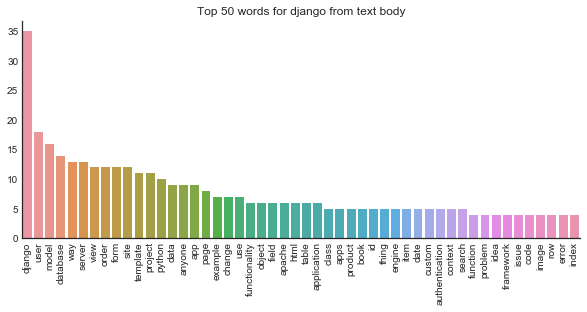

In [381]:
token_index = 76
key = list(sorted_corpfreq_body.keys())[token_index]
corptags_key_body, corptags_value_body = zip(*sorted_corpfreq_body[key])
fig, ax = plt.subplots(figsize=(10, 4))
n_element = 50
sns.barplot(
    np.array(corptags_key_body[:n_element]),
    np.array(corptags_value_body[:n_element]),
    ax=ax)
ax.set_xticklabels(corptags_key_body[:n_element], rotation=90)
ax.set_title(
    'Top 50 words for %s from text body' %key)
sns.despine()

__Observation__:
- From text.body and text.title, the tag words appear the most often in the word distrbution. For example, 
    - {tagword: *python*, word_distrb: {python: 280, way: 120...}
    - {tagword: *performance*, word_distrb: {performance: 120, time: 50...}
    - {tagword: *html*, word_distrb: {html: 150, page: 80...}
- This implies that we can rely on the presence of certain words to correctly predict tags

# Supervised learning: ScikitLearn OneVsRest Classifier

## Use text body only
### Train/crossval/test split
We create a corpus from the train set. This corpus contains the n most frequent words in each tag. We have seen previously that the tag is often found in the text body.

In [557]:
# Label binarization
from sklearn.preprocessing import MultiLabelBinarizer

lb = MultiLabelBinarizer()
targets = lb.fit_transform(df_stags_reduced)

### Feature engineering by count vectorization

In [571]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df_text_reduced.BODY_LEMMATIZED)
X_counts.shape

(8805, 39701)

In [591]:
# shuffle indices
idx = np.arange(X_counts.shape[0])
np.random.shuffle(idx, random_state=2)

# Generate train/crossval/test sets
train_size = int(.6 * X_counts.shape[0])
crossval_size = int(.8 * X_counts.shape[0])

X_train = X_counts[idx[:train_size],:]
y_train = targets[idx[:train_size],:]
X_crossval = X_counts[idx[train_size:crossval_size],:]
y_crossval = targets[idx[train_size:crossval_size],:]
X_test = X_counts[idx[crossval_size:],:]
y_test = targets[idx[crossval_size:],:]

In [598]:
X_train.shape

(5283, 39701)

### Training

In [604]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC(kernel='linear'))
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

### Cross validation

In [619]:
# identify error guesses
errors_body = []
for (index, features) in enumerate(X_crossval):
    y_crossval_predict = clf.predict(features)

    if not np.array_equal(y_crossval_predict.flatten(), y_crossval[index]):
        errors_body.append((lb.inverse_transform(y_crossval[index].reshape(1,-1)),
                            lb.inverse_transform(y_crossval_predict),
                            features))

### Evaluation: accuracy

In [620]:
train_score = clf.score(X_train,y_train)
crossval_score = clf.score(X_crossval,y_crossval)
test_score = clf.score(X_test,y_test)

print("Accuracy score:")
print("Train score: %.2f" %train_score)
print("Crossval score: %.2f" %crossval_score)
print("Test score: %.2f" %test_score)

Accuracy score:
Train score: 1.00
Crossval score: 0.08
Test score: 0.10


## Tokenizing text with count vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_size)
X_train_counts.shape
(2257, 35788)

### Corpus creation

__Use of tags in train set as corpus__


In [359]:
corpus_dict_tags = set(train_freq_body.keys())

### Feature engineering
From the corpus, we look at tokens of each document. If the token is found in the corpus, then we attribute True to feature 'contain(word)', else False.

In [360]:
def featuregenerator(data, corpus_dict):
    features = {}

    for word in corpus_dict:
        features['contains({})'.format(word)] = (word in set(data))
    return features

In [361]:
train_featuresets_body = []
#n_words = 10
for index, row in train_crossval_set_body.iterrows():
    for key in row.elkey:
        #sorted_elvalue = sorted(
        #    FreqDist(row.elvalue).items(), key=itemgetter(1), reverse=True)
        #fd_elvalue =  FreqDist(row.elvalue)
        #existing_keywords = {i:fd_elvalue[i] for i in set(fd_elvalue.keys()).intersection(most_frequent_words[key])}
        #pdb.set_trace()
        #featuresets.append((dict(sorted_elvalue), key))
        #featuresets.append(({i:True for i in row.elvalue},key))
        train_featuresets_body.append((featuregenerator(
            row.elvalue, corpus_dict_tags), key))

### Train/crossval split
Proportion of train/crossval:80/20


In [362]:
import random

random.seed(32)
shuffled_train_featuresets_body = random.sample(train_featuresets_body,
                                                len(train_featuresets_body))
train_size = int(0.8 * len(shuffled_train_featuresets_body))

train_body = shuffled_train_featuresets_body[:train_size]
crossval_body = shuffled_train_featuresets_body[train_size:]

### Training

In [363]:
from nltk import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(train_body)

### Cross validation

In [364]:
# identify error guesses
errors_body = []
for (features, tag) in crossval_body:
    guess = classifier.classify(features)
    if guess != tag:
        errors_body.append( (tag, guess, features) )

In [365]:
# display error guesses
for (tag, guess, features) in errors_body[:10]:
    #print(tag, guess, features)
    print('correct={:}, guess={:}, features={:}'.format(tag, guess, features))

correct=cruisecontrol.net, guess=.net, features={'contains(winforms)': False, 'contains(plugins)': False, 'contains(browser)': False, 'contains(outlook)': False, 'contains(css)': False, 'contains(asp.net-mvc)': False, 'contains(syntax)': False, 'contains(compiler-construction)': False, 'contains(project-management)': False, 'contains(indexing)': False, 'contains(sharepoint)': False, 'contains(unit-testing)': False, 'contains(data-binding)': False, 'contains(asp-classic)': False, 'contains(installer)': False, 'contains(iis)': False, 'contains(build-process)': False, 'contains(bash)': False, 'contains(javascript)': False, 'contains(debugging)': False, 'contains(postgresql)': False, 'contains(svn)': False, 'contains(file)': True, 'contains(firefox)': False, 'contains(jquery)': False, 'contains(shell)': False, 'contains(git)': False, 'contains(templates)': False, 'contains(linq)': False, 'contains(unix)': False, 'contains(language-agnostic)': False, 'contains(django)': False, 'contains(mat

__Observation__:
- some guesses are very close to the correct ones, such as correct=testing, guess=unit-testing, or correct=.net, guess=vb.net
- errors are more often commited when all the word features are false... (a more detailed look has to be done)

### Generation of test featureset

In [366]:
test_body = []

for index, row in test_set_body.iterrows():
    for key in row.elkey:
        #sorted_elvalue = sorted(
        #    FreqDist(row.elvalue).items(), key=itemgetter(1), reverse=True)
        #fd_elvalue =  FreqDist(row.elvalue)
        #existing_keywords = {i:fd_elvalue[i] for i in set(fd_elvalue.keys()).intersection(most_frequent_words[key])}
        #pdb.set_trace()
        #featuresets.append((dict(sorted_elvalue), key))    
        #featuresets.append(({i:True for i in row.elvalue},key))
        test_body.append((featuregenerator(row.elvalue, corpus_dict_tags), key))

### Scoring

In [367]:
from nltk.classify import accuracy
train_score_body = accuracy(classifier, train_body)
crossval_score_body = accuracy(classifier, crossval_body)
test_score_body = accuracy(classifier, test_body)

print("Train/test_score:")
print("Train score(accuracy): %.2f" % train_score_body)
print("Crossval score(accuracy): %.2f" % crossval_score_body)
print("Test score(accuracy): %.2f" % test_score_body)

Train/test_score:
Train score(accuracy): 0.25
Crossval score(accuracy): 0.20
Test score(accuracy): 0.22


In [368]:
classifier.show_most_informative_features()

Most Informative Features
         contains(video) = True            video : c#     =    440.4 : 1.0
    contains(powershell) = True           powers : .net   =    394.7 : 1.0
        contains(apache) = True           apache : c#     =    359.0 : 1.0
   contains(tortoisesvn) = True           tortoi : .net   =    354.7 : 1.0
    contains(sharepoint) = True           sharep : c#     =    336.9 : 1.0
     contains(hibernate) = True           hibern : .net   =    330.7 : 1.0
        contains(delphi) = True           delphi : .net   =    322.8 : 1.0
        contains(jquery) = True           jquery : .net   =    312.8 : 1.0
        contains(backup) = True           backup : c#     =    295.1 : 1.0
           contains(pdf) = True              pdf : c#     =    271.6 : 1.0


__Observation__:
- Train/test score are rather low, we can try to include title in hope of improving the prediction.

## Use body + title
### Feature engineering
- include all freqdist(tokens) from the title when available directly into the featuresets

In [369]:
# train crossval set
train_featuresets_body_title = []
#n_words = 10
for index, row in train_crossval_set_body.iterrows():
    for key in row.elkey:
        #sorted_elvalue = sorted(
        #    FreqDist(row.elvalue).items(), key=itemgetter(1), reverse=True)
        #fd_elvalue =  FreqDist(row.elvalue)
        #existing_keywords = {i:fd_elvalue[i] for i in set(fd_elvalue.keys()).intersection(most_frequent_words[key])}
        #pdb.set_trace()
        #featuresets.append((dict(sorted_elvalue), key))
        #featuresets.append(({i:True for i in row.elvalue},key))
        train_featuresets_body_title.append((featuregenerator(
            row.elvalue + df_tags_title.loc[index].elvalue, corpus_dict_tags),
                                             key))

### Train/crossval/test split

In [370]:
random.seed(32)
shuffled_train_featuresets_body_title = random.sample(train_featuresets_body_title, len(train_featuresets_body_title))
train_size = int(0.8 * len(shuffled_train_featuresets_body_title))

train_body_title = shuffled_train_featuresets_body_title[:train_size]
crossval_body_title = shuffled_train_featuresets_body_title[train_size:]

### Training

In [371]:
from nltk import NaiveBayesClassifier

classifier_body_title = NaiveBayesClassifier.train(train_body_title)

### Cross validation

In [372]:
# identify error guesses
errors_body_title  = []
for (features, tag) in crossval_body_title:
    guess = classifier_body_title.classify(features)
    if guess != tag:
        errors_body_title.append( (tag, guess, features) )

In [373]:
# display error guesses
for (tag, guess, features) in errors_body_title[:10]:
    print('correct={:}, guess={:}, features={:}'.format(tag, guess, list(features)))

correct=outlook, guess=windows, features=['contains(winforms)', 'contains(plugins)', 'contains(browser)', 'contains(outlook)', 'contains(css)', 'contains(asp.net-mvc)', 'contains(syntax)', 'contains(compiler-construction)', 'contains(project-management)', 'contains(indexing)', 'contains(sharepoint)', 'contains(unit-testing)', 'contains(data-binding)', 'contains(asp-classic)', 'contains(installer)', 'contains(iis)', 'contains(build-process)', 'contains(bash)', 'contains(javascript)', 'contains(debugging)', 'contains(postgresql)', 'contains(svn)', 'contains(file)', 'contains(firefox)', 'contains(jquery)', 'contains(shell)', 'contains(git)', 'contains(templates)', 'contains(linq)', 'contains(unix)', 'contains(language-agnostic)', 'contains(django)', 'contains(math)', 'contains(configuration)', 'contains(com)', 'contains(objective-c)', 'contains(networking)', 'contains(caching)', 'contains(ms-access)', 'contains(java)', 'contains(algorithm)', 'contains(vb6)', 'contains(linq-to-sql)', 'cont

### Generation of test featureset

In [374]:
test_body_title = []

for index, row in test_set_body.iterrows():
    for key in row.elkey:
        #sorted_elvalue = sorted(
        #    FreqDist(row.elvalue).items(), key=itemgetter(1), reverse=True)
        #fd_elvalue =  FreqDist(row.elvalue)
        #existing_keywords = {i:fd_elvalue[i] for i in set(fd_elvalue.keys()).intersection(most_frequent_words[key])}
        #pdb.set_trace()
        #featuresets.append((dict(sorted_elvalue), key))
        #featuresets.append(({i:True for i in row.elvalue},key))
        test_body_title.append(
            (featuregenerator(row.elvalue + df_tags_title.loc[index].elvalue,
                              corpus_dict_tags), key))

### Scoring

In [375]:
from nltk.classify import accuracy
train_score_body_title = accuracy(classifier, train_body_title)
crossval_score_body_title = accuracy(classifier, crossval_body_title)
test_score_body_title = accuracy(classifier, test_body_title)

print("Train/test_score:")
print("Train score(accuracy): %.2f" % train_score_body_title)
print("Crossval score(accuracy): %.2f" % crossval_score_body_title)
print("Test score(accuracy): %.2f" % test_score_body_title)

Train/test_score:
Train score(accuracy): 0.29
Crossval score(accuracy): 0.25
Test score(accuracy): 0.26


In [376]:
classifier_body_title.show_most_informative_features()

Most Informative Features
         contains(video) = True            video : c#     =    470.8 : 1.0
    contains(sharepoint) = True           sharep : c#     =    447.3 : 1.0
    contains(powershell) = True           powers : .net   =    416.0 : 1.0
        contains(jquery) = True           jquery : .net   =    405.5 : 1.0
        contains(apache) = True           apache : c#     =    403.2 : 1.0
     contains(hibernate) = True           hibern : .net   =    394.7 : 1.0
           contains(pdf) = True              pdf : .net   =    355.8 : 1.0
   contains(tortoisesvn) = True           tortoi : .net   =    354.7 : 1.0
          contains(ruby) = True             ruby : c#     =    354.0 : 1.0
        contains(delphi) = True           delphi : .net   =    349.2 : 1.0


__Observation__:
- The scoring is a little better with text body + title
- Naïve Bayes model doesn't return a good test score. Possible explorations to increase the test score:
    - Use another model
    - Include more data
    - Feature enginnering